# First-break picking model

## Content
* [Problem description](#Problem-description)
* [Dataset](#Dataset)
* [Model architecture](#Model-architecture)
* [Training](#Training)
* [Inference](#Inference)
* [Model evaluation](#Model-evaluation)
* [Conclusion](#Conclusion)

## Problem description

Each seismic trace has a time lag before a seismic wave, originated at the shot point, arrives the receiver. This time lag should be specified to enable trace alingment and velocity estimation.

## Dataset

476 2D seismograms.

Index field records in SEGY files and merge with field records in SPS files:

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import dill
import matplotlib.pyplot as plt
from functools import partial
from hmmlearn import hmm

sys.path.append('..')

from geolog.batchflow import Dataset, Pipeline, B, V, F

from geolog.src import SeismicBatch, FieldIndex, TraceIndex, merge_picking_files
from geolog.models import HMModel, make_hmm_data

path_raw = '/notebooks/egor/2D_Valyton/prof_37/segy/*.sgy'
dfx = pd.read_csv('/notebooks/egor/2D_Valyton/sps/ALL_VALUNT0910_X37.csv')
dfr = pd.read_csv('/notebooks/egor/2D_Valyton/sps/ALL_VALUNT0910_R_utm.csv')
dfs = pd.read_csv('/notebooks/egor/2D_Valyton/sps/ALL_VALUNT0910_S_utm.csv')

index = (FieldIndex(name='raw', extra_headers=['ShotPoint'], path=path_raw).drop_duplicates(keep='last')
         .merge(FieldIndex(dfx=dfx, dfr=dfr, dfs=dfs)))
         
index.head()

,ShotPoint,TraceNumber,TRACE_SEQUENCE_FILE,file_id,sline,sid,rline,rid,point_index,sht_depth,...,SourceX,SourceY,z_s,x_r,y_r,z_r,CDP_X,CDP_Y,azimuth,offset
,,,raw,raw,,,,,,,...,,,,,,,,,,
FieldRecord,,,,,,,,,,,,,,,,,,,,,
354,0,1,3,/notebooks/egor/2D_Valyton/prof_37/segy/000003...,S37,3591,R37,219,1,18.0,...,338886.78,7033413.0,71.5,338560.00,7029929.5,76.0,338723.39,7031671.25,-1.664331,1749.396855
354,0,2,4,/notebooks/egor/2D_Valyton/prof_37/segy/000003...,S37,3591,R37,220,1,18.0,...,338886.78,7033413.0,71.5,338562.40,7029954.5,76.1,338724.59,7031683.75,-1.664315,1736.839416
354,0,3,5,/notebooks/egor/2D_Valyton/prof_37/segy/000003...,S37,3591,R37,221,1,18.0,...,338886.78,7033413.0,71.5,338564.70,7029979.5,76.2,338725.74,7031696.25,-1.664328,1724.286648
354,0,4,6,/notebooks/egor/2D_Valyton/prof_37/segy/000003...,S37,3591,R37,222,1,18.0,...,338886.78,7033413.0,71.5,338567.00,7030004.5,76.8,338726.89,7031708.75,-1.664341,1711.733880
354,0,5,7,/notebooks/egor/2D_Valyton/prof_37/segy/000003...,S37,3591,R37,223,1,18.0,...,338886.78,7033413.0,71.5,338569.38,7030029.0,77.4,338728.08,7031721.00,-1.664317,1699.426283


Set first field record as a traning subset:

Load and the training seismogram:

In [2]:
batch = (Dataset(index, SeismicBatch).next_batch(3)
         .load(components='raw', fmt='segy')
         .sort_traces(src='raw', dst='raw', sort_by='offset'))

Show the training seismogram:

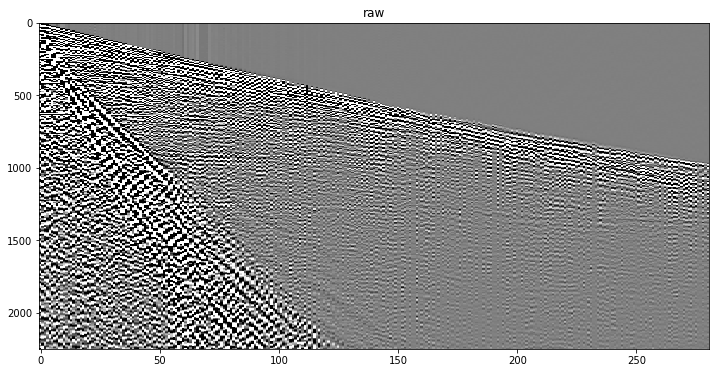

In [3]:
cv = 1
batch.imshow('raw', batch.indices[0], figsize=(12, 6), vmin=-cv, vmax=cv, cmap='gray')

## Model architecture

We exploit a Hidden Markov Model with 2 hidden states. It is supposed that one state corresponds to signal, while the second one corresponds to noise (no-signal). The first change from noise state to signal state is assosiated with seismic wave arrival (first-break moment). It is also supposed that at  each trace is more likely to start at noise state.

Model config:

In [4]:
config_train = {
    'build': True,
    'estimator': hmm.GaussianHMM(n_components=2, n_iter=20, covariance_type="full")
}

## Training

Define a train dataset:

In [5]:
train_index = index.create_subset(index.indices[:1])
train_set = Dataset(TraceIndex(train_index), SeismicBatch)

Model training pipeline:

In [6]:
batch_size = 1
cv = 3

train_pipeline = (Pipeline()
                 .init_model('dynamic', HMModel, 'HMM', config=config_train)
                 .load(components='raw', fmt='segy')
                 .clip(a_min=-cv, a_max=cv, src='raw', dst='raw')
                 .gradient(src='raw', dst='raw')
                 .cwt(src='raw', dst='raw', scales=[4], wavelet='mexh')
                 .train_model('HMM', make_data=partial(make_hmm_data, components='raw'))
                 .run(batch_size=batch_size, n_epochs=1, shuffle=False, drop_last=False, lazy=True))

Run the training pipeline:

In [7]:
(train_set >> train_pipeline).run()

Dump the trained model:

In [8]:
train_pipeline.save_model("HMM", path="__picks_model.dill")

## Model evaluation

Inference config:

In [9]:
hmmodel_path = "__picks_model.dill"

config_predict = {
    'build': False,
    'load': {'path': hmmodel_path}
}

with open(hmmodel_path, "rb") as file:
    hmmodel = dill.load(file)
signal_label = np.argmin(hmmodel.startprob_)

def get_first_arrival(arr, signal_label):
    indices = np.where(arr == signal_label)[0]
    return indices[0] if len(indices) else -1

Test pipeline:

In [10]:
batch_size = 100
cv = 3

test_pipeline = (Pipeline()
                 .init_model('static', HMModel, 'HMM', config=config_predict)
                 .load(components='raw', fmt='segy')
                 .sort_traces(src='raw', dst='raw', sort_by='offset')
                 .clip(a_min=-cv, a_max=cv, src='raw', dst='raw')
                 .gradient(src='raw', dst='grad')
                 .cwt(src='grad', dst='wavelet', scales=[4], wavelet='mexh')
                 .predict_model('HMM', make_data=partial(make_hmm_data, components='wavelet'),
                                save_to=B('hmm_predictions'), mode='w')
                 .to_2d(src='hmm_predictions', dst='hmm_predictions')
                 .apply_along_axis(get_first_arrival, src='hmm_predictions',
                                 dst='hmm_predictions', signal_label=signal_label)
                 .run(batch_size=batch_size, shuffle=False, drop_last=False, n_epochs=1, lazy=True)
                )

Run pipeline on a test subset (10 field records):

In [11]:
test_set = Dataset(index.create_subset(index.indices[90:100]), SeismicBatch)
batch = (test_set >> test_pipeline).next_batch(10)

Show test seismograms and first-break picks:

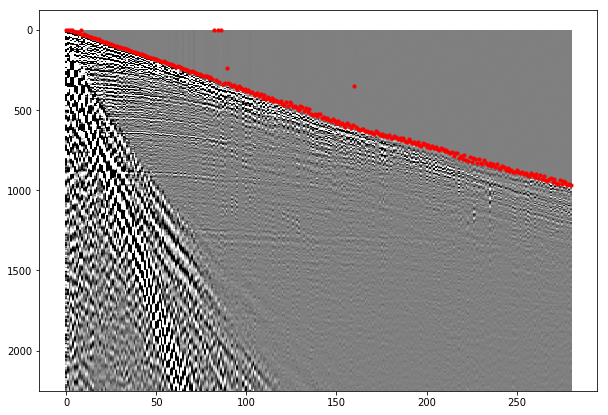

In [12]:
i = 0
picks = batch.hmm_predictions[i]

plt.figure(figsize=(10, 7))
plt.imshow(batch.raw[i].T, cmap='gray')
plt.scatter(np.arange(len(picks)), picks, s=10, c='r')
plt.axes().set_aspect('auto')
plt.show()

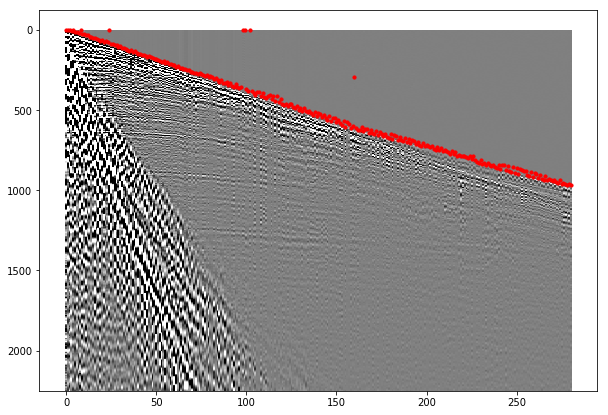

In [13]:
i = 4
picks = batch.hmm_predictions[i]

plt.figure(figsize=(10, 7))
plt.imshow(batch.raw[i].T, cmap='gray')
plt.scatter(np.arange(len(picks)), picks, s=10, c='r')
plt.axes().set_aspect('auto')
plt.show()

## Inference

Inference pipeline with dump action:

In [14]:
cv = 3
dump_path = '/notebooks/egor/geolog/notebooks/dumps'

predict_pipeline = (Pipeline()
                    .init_model('static', HMModel, 'HMM', config=config_predict)
                    .init_variable('count', init_on_each_run=0)
                    .load(components='raw', fmt='segy')
                    .clip(a_min=-cv, a_max=cv, src='raw', dst='raw')
                    .gradient(src='raw', dst='raw')
                    .cwt(src='raw', dst='raw', scales=[4], wavelet='mexh')
                    .predict_model('HMM', make_data=partial(make_hmm_data, components='raw'),
                                   save_to=B('hmm_predictions'), mode='w')
                    .to_2d(src='hmm_predictions', dst='hmm_predictions')
                    .apply_along_axis(get_first_arrival, src='hmm_predictions',
                                      dst='hmm_predictions', signal_label=signal_label)
                    .dump(fmt='picks', src='hmm_predictions', traces='raw', to_samples=True,
                          path=F(lambda _, x: os.path.join(dump_path, str(x) + '.pks'), V('count')))
                    .update_variable('count', F(lambda _, x: x + 1, V('count'))))

Run pipeline:

In [15]:
batch_size = 5000
predict_pipeline = predict_pipeline << Dataset(TraceIndex(index), SeismicBatch)
predict_pipeline.run(batch_size, n_epochs=1, drop_last=False, shuffle=False, bar=True)

 95%|█████████▌| 20/21 [05:41<00:18, 18.13s/it]


Merge output files into single one:

In [17]:
merge_picking_files(path=os.path.join(dump_path, '*pks'),
                    output_path='/notebooks/egor/geolog/notebooks/merged.pks')

Done!